# Save and Upload a Model to S3

Save a trained model in ONNX format and upload the file to an S3 bucket.

### 1. Import the required libraries

In [1]:
import os
import boto3
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.svm import OneClassSVM

from skl2onnx import to_onnx

### 2. Train a sample model

Generate a random data set of normally-distributed data points.

In [2]:
X, _ = make_blobs(100, centers=1, n_features=2, random_state=0)

In [5]:
X[0:10]

array([[ 0.11504439,  6.21385228],
       [ 0.08848433,  2.32299086],
       [-0.51498751,  4.74317903],
       [ 1.37227679,  3.21072582],
       [-0.12811326,  4.35595241],
       [ 0.93698726,  3.13569383],
       [ 1.60150153,  2.70172967],
       [-0.29421492,  5.27318404],
       [ 1.1312175 ,  4.68194985],
       [-0.05797276,  4.98538185]])

Train a model for anomaly detection by using the generated data.

In [6]:
model = OneClassSVM(nu=0.1)
model.fit(X)

OneClassSVM(nu=0.1)

Run the anomaly detection model.

In [7]:
y_pred = model.predict(X)

Plot the results.
The diagram displays anomalies in red.

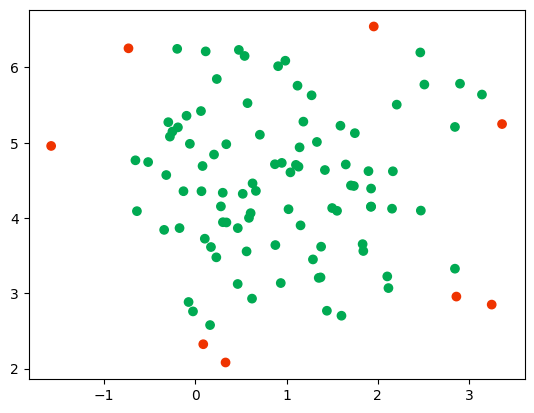

In [8]:
colors = np.array([
    "#ef3300",  # Outlier -> Anomaly
    "#00aa52",  # Inlier -> Ok
])
is_inlier = (y_pred + 1) // 2
y_pred_colors = colors[is_inlier]
plt.scatter(X[:, 0], X[:, 1], color=y_pred_colors)

### 3. Export the trained model to ONNX

Use a single sample row for the model to infer the input shape.

In [9]:
sample_row = X[:1]
sample_row

array([[0.11504439, 6.21385228]])

Convert the Scikit-learn model to ONNX.

In [10]:
onnx_model = to_onnx(model, sample_row)
onnx_model

ir_version: 10
opset_import {
  domain: "ai.onnx.ml"
  version: 1
}
opset_import {
  domain: ""
  version: 9
}
producer_name: "skl2onnx"
producer_version: "1.17.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "SVMO1"
    name: "SVM"
    op_type: "SVMRegressor"
    domain: "ai.onnx.ml"
    attribute {
      name: "coefficients"
      type: FLOATS
      floats: 1
      floats: 1
      floats: 0.872122288
      floats: 1
      floats: 1
      floats: 1
      floats: 0.940240502
      floats: 1
      floats: 0.373928308
      floats: 0.813708901
      floats: 1
    }
    attribute {
      name: "kernel_params"
      type: FLOATS
      floats: 0.123098947
      floats: 0
      floats: 3
    }
    attribute {
      name: "kernel_type"
      type: STRING
      s: "RBF"
    }
    attribute {
      name: "n_supports"
      type: INT
      i: 11
    }
    attribute {
      name: "post_transform"
      type: STRING
      s: "NONE"
    }
    attribu

Save the ONNX model to a file.

In [11]:
onnx_file_name = "anomaly_detection.onnx"

with open(onnx_file_name, "wb") as f:
    f.write(onnx_model.SerializeToString())

### 4. Upload the file to the S3 bucket.

Use the `boto3` library with the parameters of the data connection.

> **IMPORTANT**
>
> The `verify=False` parameter ignores the errors caused by the self-signed certificates of the lab environment.
> In production, you should always remove this parameter to verify the SSL certificates of your S3 services.

In [12]:
key_id = os.getenv("AWS_ACCESS_KEY_ID")
secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
endpoint = os.getenv("AWS_S3_ENDPOINT")
bucket_name = os.getenv("AWS_S3_BUCKET")

s3_client = boto3.client(
    "s3",
    aws_access_key_id=key_id,
    aws_secret_access_key=secret_key,
    endpoint_url=endpoint,
    verify=False
)

s3_client.upload_file(onnx_file_name, bucket_name, Key=onnx_file_name)

print(f"File {onnx_file_name} uploaded to S3!")

/opt/app-root/lib64/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 's3-openshift-storage.apps.mlops.software.bl.platform'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


File anomaly_detection.onnx uploaded to S3!


Open https://minio-minio.apps.ocp4.example.com/.

Authenticate with the `minio` access key and the `minio123` secret key.

Verify that the `saved-models` bucket contains the ONNX model file.